**Please note that the 01_setup notebook should be executed before running this notebook**

In [1]:
import os
from icecream import ic
# Get original notebook path and LD_LIBRARY_PATH
notebook_path = ic(os.getcwd())
original_ld_library_path = ic(os.environ.get('LD_LIBRARY_PATH'))
# Software and install_prefix as defined in 01_setup.ipynb
software_path = ic(os.path.join(notebook_path, 'sjk012', 'software'))
install_prefix = ic(os.path.join(software_path, 'opt'))

ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


In [2]:
import os
# from icecream import ic
# Get original notebook path and LD_LIBRARY_PATH
notebook_path = os.getcwd()
print(notebook_path)
original_ld_library_path = os.environ.get('LD_LIBRARY_PATH')
print(original_ld_library_path)
# Software and install_prefix as defined in 01_setup.ipynb
software_path = os.path.join(notebook_path, 'sjk012', 'software')
print(software_path)
install_prefix = os.path.join(software_path, 'opt')
print(install_prefix)

/home/pabloju/HPML/assignment2
None
/home/pabloju/HPML/assignment2/sjk012/software
/home/pabloju/HPML/assignment2/sjk012/software/opt


In [3]:
# Update the environment
os.environ['LD_LIBRARY_PATH'] = os.path.join(install_prefix, 'blis', 'lib')
os.environ['LD_LIBRARY_PATH'] += ":"
os.environ['LD_LIBRARY_PATH'] += os.path.join(install_prefix, 'openblas', 'lib')
if original_ld_library_path is not None:
    os.environ['LD_LIBRARY_PATH'] += ":"
    os.environ['LD_LIBRARY_PATH'] += original_ld_library_path
_ = ic(os.environ['LD_LIBRARY_PATH'])

ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


In [4]:
# Update the environment
os.environ['LD_LIBRARY_PATH'] = os.path.join(install_prefix, 'blis', 'lib')
os.environ['LD_LIBRARY_PATH'] += ":"
os.environ['LD_LIBRARY_PATH'] += os.path.join(install_prefix, 'openblas', 'lib')
if original_ld_library_path is not None:
    os.environ['LD_LIBRARY_PATH'] += ":"
    os.environ['LD_LIBRARY_PATH'] += original_ld_library_path
print(os.environ['LD_LIBRARY_PATH'])

/home/pabloju/HPML/assignment2/sjk012/software/opt/blis/lib:/home/pabloju/HPML/assignment2/sjk012/software/opt/openblas/lib


# Convolutional Networks

So far we have worked with  fully connected networks, using them to explore different optimization strategies and network architectures. Fully connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [5]:
# Setup cell
import numpy as np
import matplotlib.pyplot as plt
from sjk012.classifiers.cnn import *
from sjk012.data_utils import get_CIFAR10_data
from sjk012.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from sjk012.layers import *
# from sjk012.fast_layers import *
from sjk012.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [6]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Convolution: Naive Forward Pass

![Convolution](sjk012/img/conv.jpg) 

The convolution operation lies at the heart of convolutional neural networks. To implement the forward pass for the convolutional layer, you'll use the function `conv_forward_numpy` within the file `sjk012/layers.py`. Don't concern yourself too much with efficiency at this stage; focus on writing clear and understandable code.

### Forward Pass Formulas

The forward pass of a convolutional layer involves the following computations:

1. **Convolution operation**:

$$O[k, i, j] = b[k] + \sum_{c=0}^{C-1}  \sum_{l=0}^{K_h-1} \sum_{d=0}^{K_w-1} X[c, i+k, j+l] \cdot F[k, c, l, d]$$

Where:
   - $ O[k, i, j] $ is the value at position $ (i, j) $ of the $ k $-th channel in the output feature map.
   - $ K_h $ and $ K_w $ are the height and width of the filter, respectively.
   - $ C $ is the number of channels in the input.
   - $ X $ is the input tensor.
   - $ F $ is the filter tensor.
   - $ b $ is the bias tensor.

Implement this calculation in the `conv_forward_numpy` function.

### Testing Your Implementation

After implementing the forward pass, you can test your implementation by running the following code. This will help ensure that your convolutional layer behaves as expected.


In [7]:
x_shape = (2, 3, 5, 5)
w_shape = (3, 3, 3, 3)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape), dtype=np.float32).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape), dtype=np.float32).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3, dtype=np.float32)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_numpy(x, w, b, conv_param)
correct_out = np.array([[[[-0.06974833, -0.06704278, -0.08701342],
                          [-0.1167995 , -0.14790688, -0.1481334 ],
                          [-0.16322148, -0.21268874, -0.1877349 ]],

                         [[ 0.10607383,  0.14003775,  0.11327182],
                          [ 0.1636703 ,  0.22531879,  0.16903104],
                          [ 0.1349161 ,  0.17786492,  0.13486576]],

                         [[ 0.281896  ,  0.34711832,  0.31355706],
                          [ 0.44414014,  0.59854448,  0.48619545],
                          [ 0.43305367,  0.56841862,  0.45746642]]],


                        [[[-0.45481545, -0.6616317 , -0.49473158],
                          [-0.74536496, -1.1162374 , -0.81067538],
                          [-0.61624163, -0.90920722, -0.66340607]],

                         [[ 0.3325839 ,  0.46281463,  0.31713089],
                          [ 0.45247066,  0.63303697,  0.42385486],
                          [ 0.29347315,  0.39871228,  0.27077183]],

                         [[ 1.1199832 ,  1.58726108,  1.12899327],
                          [ 1.65030622,  2.38231134,  1.65838516],
                          [ 1.20318794,  1.70663178,  1.20494974]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.164824856030598e-08


## Aside: Image Processing via Convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

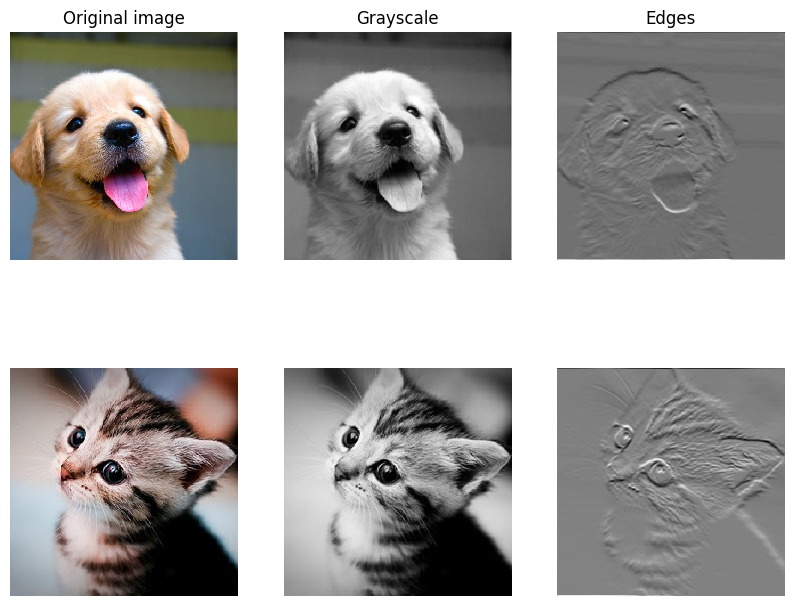

In [8]:
from imageio.v2 import imread
from PIL import Image

kitten = imread('sjk012/notebook_images/kitten.jpg')
puppy = imread('sjk012/notebook_images/puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = np.array(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = np.array(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = resized_puppy.transpose((2, 0, 1))
x[1, :, :, :] = resized_kitten.transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

###########################################################################
# TODO: The first filter converts the image to grayscale.                 #
# Second filter detects horizontal edges in the blue channel.             #
# Set up the red, green, and blue channels of the filter.                 #
###########################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# First filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]  # red channel
w[0, 1, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]  # green channel
w[0, 2, :, :] = [[0, 0, 0], [0, 1, 0], [0, 0, 0]]  # blue channel

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]  # blue channel
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################        

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_numpy(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

# Im2col Transform

Achieving efficiency in convolutional operations is crucial for enhancing the performance of convolutional neural networks. In this exercise, we'll delve into optimizing and parallelizing these operations individually.

![Im2col](sjk012/img/im2col.png) 

Open the file `sjk012/im2col/im2col.pyx` and implement the `im2col` transform using Cython. Remember to parallelize the first loop using OpenMP; you can utilize the `prange` function for this purpose.

The `im2col` implementation relies on a Cython extension. To compile it, execute the cell below.

Then, you can test its correctness by executing the next cell.

In [9]:
# Use pyximport to compile the cython modules
import pyximport
pyximport.install(reload_support=True, pyimport=True)

(<pyximport._pyximport3.PyImportMetaFinder at 0x7f5d1cde3250>,
 <pyximport._pyximport3.PyxImportMetaFinder at 0x7f5d192f68d0>)

In [12]:
# Rel errors should be around e-9 or less.
from sjk012.im2col.im2col import im2col_cython
from time import time

x_shape = (2, 3, 4, 4)
w_shape = (2, 3, 3, 3)
conv_param = {'stride': 2, 'pad': 1}

x = np.linspace(-0.1, 0.5, num=np.prod(x_shape), dtype=np.float32).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape), dtype=np.float32).reshape(w_shape)

out = im2col_cython(x, w_shape[2], w_shape[3], conv_param['pad'], conv_param['stride'])
correct_out = np.array([[ 0.          ,0.          ,0.         ,-0.06842105  ,0.          ,0.          , 0.          ,0.23473684],
                        [ 0.          ,0.         ,-0.07473684 ,-0.06210526  ,0.          ,0.          , 0.22842105  ,0.24105263],
                        [ 0.          ,0.         ,-0.06842105 ,-0.05578947  ,0.          ,0.          , 0.23473684  ,0.24736843],
                        [ 0.         ,-0.09368421  ,0.         ,-0.04315789  ,0.          ,0.20947368  , 0.          ,0.26      ],
                        [-0.1        ,-0.08736842 ,-0.04947368 ,-0.0368421   ,0.2031579   ,0.21578947  , 0.25368422  ,0.2663158 ],
                        [-0.09368421 ,-0.08105263 ,-0.04315789 ,-0.03052632  ,0.20947368  ,0.22210526  , 0.26        ,0.2726316 ],
                        [ 0.         ,-0.06842105  ,0.         ,-0.01789474  ,0.          ,0.23473684  , 0.          ,0.28526315],
                        [-0.07473684 ,-0.06210526 ,-0.02421053 ,-0.01157895  ,0.22842105  ,0.24105263  , 0.27894738  ,0.29157895],
                        [-0.06842105 ,-0.05578947 ,-0.01789474 ,-0.00526316  ,0.23473684  ,0.24736843  , 0.28526315  ,0.29789475],
                        [ 0.          ,0.          ,0.          ,0.03263158  ,0.          ,0.          , 0.          ,0.33578947],
                        [ 0.          ,0.          ,0.02631579  ,0.03894737  ,0.          ,0.          , 0.32947367  ,0.34210527],
                        [ 0.          ,0.          ,0.03263158  ,0.04526316  ,0.          ,0.          , 0.33578947  ,0.34842107],
                        [ 0.          ,0.00736842  ,0.          ,0.05789474  ,0.          ,0.3105263   , 0.          ,0.36105263],
                        [ 0.00105263  ,0.01368421  ,0.05157895  ,0.06421053  ,0.3042105   ,0.3168421   , 0.35473683  ,0.36736843],
                        [ 0.00736842  ,0.02        ,0.05789474  ,0.07052632  ,0.3105263   ,0.3231579   , 0.36105263  ,0.3736842 ],
                        [ 0.          ,0.03263158  ,0.          ,0.0831579   ,0.          ,0.33578947  , 0.          ,0.3863158 ],
                        [ 0.02631579  ,0.03894737  ,0.07684211  ,0.08947369  ,0.32947367  ,0.34210527  , 0.38        ,0.3926316 ],
                        [ 0.03263158  ,0.04526316  ,0.0831579   ,0.09578948  ,0.33578947  ,0.34842107  , 0.3863158   ,0.39894736],
                        [ 0.          ,0.          ,0.          ,0.13368422  ,0.          ,0.          , 0.          ,0.4368421 ],
                        [ 0.          ,0.          ,0.12736842  ,0.14        ,0.          ,0.          , 0.43052632  ,0.44315788],
                        [ 0.          ,0.          ,0.13368422  ,0.14631578  ,0.          ,0.          , 0.4368421   ,0.44947368],
                        [ 0.          ,0.10842105  ,0.          ,0.15894736  ,0.          ,0.41157895  , 0.          ,0.46210527],
                        [ 0.10210526  ,0.11473684  ,0.15263158  ,0.16526316  ,0.40526316  ,0.41789475  , 0.45578948  ,0.46842104],
                        [ 0.10842105  ,0.12105263  ,0.15894736  ,0.17157894  ,0.41157895  ,0.42421052  , 0.46210527  ,0.47473684],
                        [ 0.          ,0.13368422  ,0.          ,0.18421052  ,0.          ,0.4368421   ,  0.         ,0.48736843],
                        [ 0.12736842  ,0.14        ,0.17789474  ,0.19052632  ,0.43052632  ,0.44315788  , 0.48105264  ,0.4936842 ],
                        [ 0.13368422  ,0.14631578  ,0.18421052  ,0.1968421   ,0.4368421   ,0.44947368  , 0.48736843  ,0.5       ]])

# Compare your output to ours; difference should be around e-7
print('Testing im2col_cython')
print('difference: ', rel_error(out, correct_out))

Testing im2col_cython
difference:  7.271831589356479e-07


# Im2col-based Convolution

With the optimized im2col transform, you can now implement the im2col-based convolution function `conv_forward_cython` in the file `sjk012/layers.py`.

The following schema illustrates the matrix operations involved in performing the convolution using the im2col transform:

![Convolution forward](sjk012/img/conv_forward_im2col.png) 

The im2col-based convolution involves the following steps:

1. **Reshape input data**:
   
   $$X_{col} = \text{im2col}(X, R, S, \text{padding}, \text{stride})$$

2. **Reshape filters**:
   
   $$W_{row} = \text{reshape}(W, (K, R \times S \times C))$$

3. **Perform matrix multiplication**:

   $$O = W_{row} \times X_{col} + b$$

4. **Reshape output**:
   
   $$\text{output} = \text{reshape}(O, (N, K, H_o, W_o))$$

Implement these steps in the function `conv_forward_cython` to carry out the im2col-based convolution.

Once you complete the implementation, you can test its functionality using the following code:


In [15]:
x_shape = (2, 3, 5, 5)
w_shape = (3, 3, 3, 3)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape), dtype=np.float32).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape), dtype=np.float32).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3, dtype=np.float32)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_cython(x, w, b, conv_param)
correct_out = np.array([[[[-0.06974833, -0.06704278, -0.08701342],
                          [-0.1167995 , -0.14790688, -0.1481334 ],
                          [-0.16322148, -0.21268874, -0.1877349 ]],

                         [[ 0.10607383,  0.14003775,  0.11327182],
                          [ 0.1636703 ,  0.22531879,  0.16903104],
                          [ 0.1349161 ,  0.17786492,  0.13486576]],

                         [[ 0.281896  ,  0.34711832,  0.31355706],
                          [ 0.44414014,  0.59854448,  0.48619545],
                          [ 0.43305367,  0.56841862,  0.45746642]]],


                        [[[-0.45481545, -0.6616317 , -0.49473158],
                          [-0.74536496, -1.1162374 , -0.81067538],
                          [-0.61624163, -0.90920722, -0.66340607]],

                         [[ 0.3325839 ,  0.46281463,  0.31713089],
                          [ 0.45247066,  0.63303697,  0.42385486],
                          [ 0.29347315,  0.39871228,  0.27077183]],

                         [[ 1.1199832 ,  1.58726108,  1.12899327],
                          [ 1.65030622,  2.38231134,  1.65838516],
                          [ 1.20318794,  1.70663178,  1.20494974]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  7.394113681991473e-08


# Parallel Performance Evaluation

In this section, we will evaluate the performance of the numpy and im2col-based convolutions using the parallel version.

### Task Description

1. **Plot Execution Times**: Plot the execution times of both numpy and im2col-based convolutions, varying the number of threads and adjusting parameters such as batch size, number of filters, and input channels.

2. **Observations**: Analyze the execution times of each convolution version under different scenarios, considering variations in the batch size, image size, filter size, number of filters, and number of channels.

### Observations

- **Scalability with Threads**: Determine which version scales better with respect to the number of threads and other parameters.

- **Efficiency Comparison**: Assess the efficiency of each convolution version under various scenarios.

*Write your observations here:*


In [16]:
from threadpoolctl import threadpool_limits
from pprint import pprint
import time

# Define matrix sizes
image_sizes = [2**i for i in range(4, 7)]

# Filter sizes
filter_sizes = [3]
conv_param = {'stride': 1, 'pad': 1}

# Number of repetitions
repetitions = 3

thread_range = [1, 2, 4, 8, 16, 24]

# Initialize arrays to store execution times
numpy_times = np.zeros((len(image_sizes), len(filter_sizes), len(thread_range)))
cython_times = np.zeros((len(image_sizes), len(filter_sizes), len(thread_range)))

for num_threads, n_threads in enumerate(thread_range):
    with threadpool_limits(limits=n_threads):
        
        # Measure performance for each size
        for idx_size, size in enumerate(image_sizes):
            print(f"Image size: {size} x {size}, Threads: {n_threads}")

            for idx_filter, filter_size in enumerate(filter_sizes):
                # Initialize arrays to store execution times for current size and filter size
                numpy_times_size = []
                cython_times_size = []
                
                x = np.random.randn(32, 3, size, size).astype(np.float32)
                w = np.random.randn(5, 3, filter_size, filter_size).astype(np.float32)
                b = np.random.randn(5).astype(np.float32)

                for _ in range(repetitions):
                    pass
                    ###########################################################################
                    # TODO: Call the corresponding versions of the convolution and append the #
                    # times to the previously created vectors                                  #
                    ###########################################################################
                    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                    # Measure numpy time
                    start = time.time()
                    out, _ = conv_forward_numpy(x, w, b, conv_param)
                    numpy_times_size.append(time.time() - start)

                    # Measure cython time
                    start = time.time()
                    out, _ = conv_forward_cython(x, w, b, conv_param)
                    cython_times_size.append(time.time() - start)
                    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
                    ###########################################################################
                    #                             END OF YOUR CODE                            #
                    ###########################################################################            

                # Compute average execution times for current size, filter size, and number of threads
                numpy_times[idx_size, idx_filter, num_threads] = np.mean(numpy_times_size)
                cython_times[idx_size, idx_filter, num_threads] = np.mean(cython_times_size)

Image size: 16 x 16, Threads: 1
Image size: 32 x 32, Threads: 1
Image size: 64 x 64, Threads: 1
Image size: 16 x 16, Threads: 2
Image size: 32 x 32, Threads: 2
Image size: 64 x 64, Threads: 2
Image size: 16 x 16, Threads: 4
Image size: 32 x 32, Threads: 4
Image size: 64 x 64, Threads: 4
Image size: 16 x 16, Threads: 8
Image size: 32 x 32, Threads: 8
Image size: 64 x 64, Threads: 8
Image size: 16 x 16, Threads: 16
Image size: 32 x 32, Threads: 16
Image size: 64 x 64, Threads: 16
Image size: 16 x 16, Threads: 24
Image size: 32 x 32, Threads: 24
Image size: 64 x 64, Threads: 24


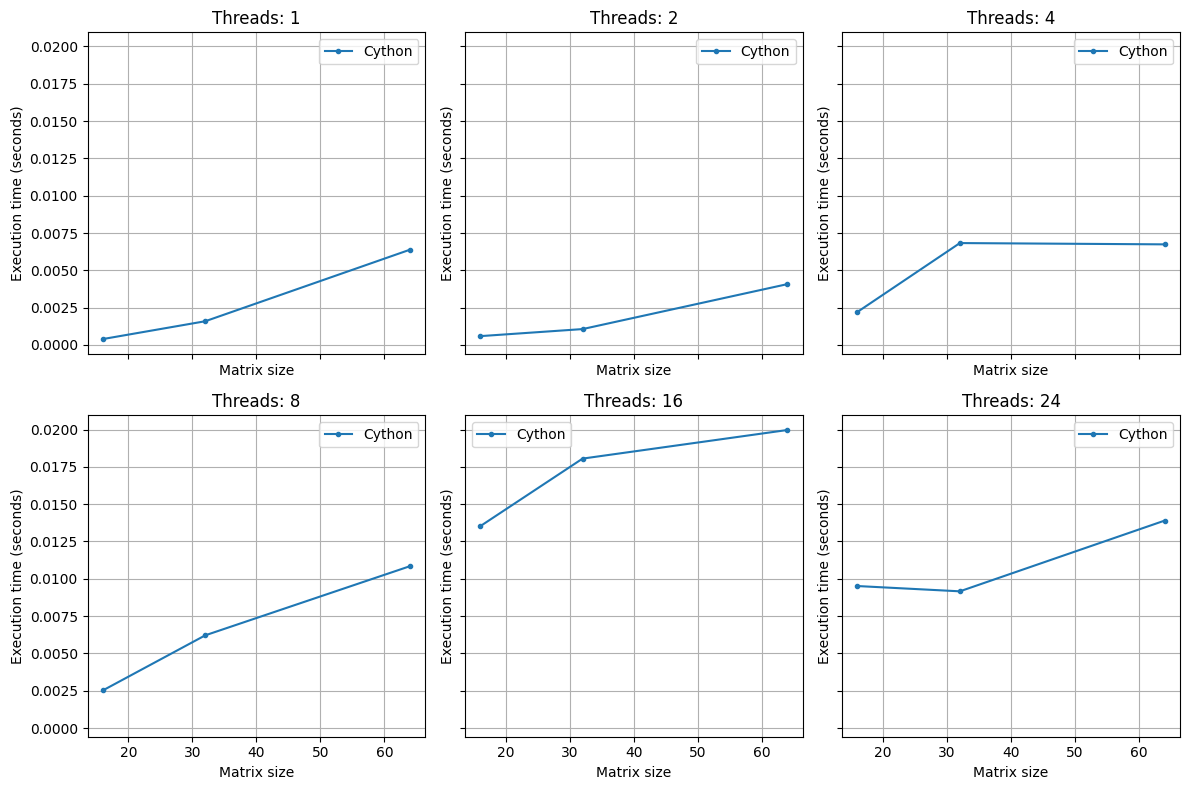

In [17]:
# Plotting subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, n_threads in enumerate([1, 2, 4, 8, 16, 24]):
    row = i // 3
    col = i % 3
    #axs[row, col].plot(image_sizes, numpy_times[..., i], marker='o', label=f'NumPy')
    axs[row, col].plot(image_sizes, cython_times[..., i], marker='.', label=f'Cython')
    axs[row, col].set_title(f'Threads: {n_threads}')
    axs[row, col].set_xlabel('Matrix size')
    axs[row, col].set_ylabel('Execution time (seconds)')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

# Convolution: Naive Backward Pass

![Convolution Backward](sjk012/img/conv_backward.png) 

To implement the backward pass for the convolution operation, you can utilize the following formulas:

1. **Compute the gradient with respect to the input** ($\nabla X$):

$$\nabla X[c, i, j] = \sum_{l=0}^{K_h-1} \sum_{d=0}^{K_w-1} \sum_{k=0}^{K-1} F[k, c, l, d] \cdot \nabla O[k, i+l, j+d]$$

2. **Compute the gradient with respect to the filters** ($\nabla F$):

$$\nabla F[k, l, d] = \sum_{i=0}^{H_{out}-1} \sum_{j=0}^{W_{out}-1} \nabla O[k, i, j] \cdot X[i+l, j+d]$$

3. **Compute the gradient with respect to the bias** ($\nabla b$):

$$\nabla b = \sum_{i=0}^{H_{out}-1} \sum_{j=0}^{W_{out}-1} \nabla O[:, i, j]$$


Implement these calculations in the function `conv_backward_numpy` within the file `sjk012/layers.py`. Don't worry too much about computational efficiency at this stage.

After implementation, run the following code to verify your backward pass with a numeric gradient check.


In [18]:
np.random.seed(12)
x = np.random.randn(4, 3, 5, 5).astype(np.float32)
w = np.random.randn(2, 3, 3, 3).astype(np.float32)
b = np.random.randn(2,).astype(np.float32)
dy = np.random.randn(4, 2, 5, 5).astype(np.float32)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_numpy(x, w, b, conv_param)[0], x, dy, h=1e-2)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_numpy(x, w, b, conv_param)[0], w, dy, h=1e-2)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_numpy(x, w, b, conv_param)[0], b, dy, h=1e-2)

out, cache = conv_forward_numpy(x, w, b, conv_param)
dx, dw, db = conv_backward_numpy(dy, cache)

# Your errors should be around e-3 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  0.00086615735
dw error:  0.00012968341
db error:  3.0325555e-06


# Col2im transform

In this exercise we will learn to individually optimise and parallelise the backward convolution using the col2im transform, which corresponds to the inverse of the im2col.

![col2im](sjk012/img/col2im.gif)

Open the `sjk012/col2im/col2im.pyx` and implement the col2im transform using Cython. Remember to parallelise the first loop using OpenMP, use the `prange` function.

The im2col implementation depends on a Cython extension; to compile it, run the cell below. Next, save the Colab notebook (`File > Save`) and **restart the runtime** (`Runtime > Restart runtime`). You can then re-execute the preceeding cells from top to bottom and skip the cell below as you only need to run it once for the compilation step.

Once you are done, you can test the correct workings executing this code:

In [19]:
# Rel errors should be around e-9 or less.
from sjk012.col2im.col2im import col2im_cython
from time import time

x_shape = (2, 3, 4, 4)
w_shape = (2, 3, 3, 3)
conv_param = {'stride': 2, 'pad': 1}

cols_output = np.array([[ 0.          ,0.          ,0.         ,-0.06842105  ,0.          ,0.          , 0.          ,0.23473684],
                        [ 0.          ,0.         ,-0.07473684 ,-0.06210526  ,0.          ,0.          , 0.22842105  ,0.24105263],
                        [ 0.          ,0.         ,-0.06842105 ,-0.05578947  ,0.          ,0.          , 0.23473684  ,0.24736843],
                        [ 0.         ,-0.09368421  ,0.         ,-0.04315789  ,0.          ,0.20947368  , 0.          ,0.26      ],
                        [-0.1        ,-0.08736842 ,-0.04947368 ,-0.0368421   ,0.2031579   ,0.21578947  , 0.25368422  ,0.2663158 ],
                        [-0.09368421 ,-0.08105263 ,-0.04315789 ,-0.03052632  ,0.20947368  ,0.22210526  , 0.26        ,0.2726316 ],
                        [ 0.         ,-0.06842105  ,0.         ,-0.01789474  ,0.          ,0.23473684  , 0.          ,0.28526315],
                        [-0.07473684 ,-0.06210526 ,-0.02421053 ,-0.01157895  ,0.22842105  ,0.24105263  , 0.27894738  ,0.29157895],
                        [-0.06842105 ,-0.05578947 ,-0.01789474 ,-0.00526316  ,0.23473684  ,0.24736843  , 0.28526315  ,0.29789475],
                        [ 0.          ,0.          ,0.          ,0.03263158  ,0.          ,0.          , 0.          ,0.33578947],
                        [ 0.          ,0.          ,0.02631579  ,0.03894737  ,0.          ,0.          , 0.32947367  ,0.34210527],
                        [ 0.          ,0.          ,0.03263158  ,0.04526316  ,0.          ,0.          , 0.33578947  ,0.34842107],
                        [ 0.          ,0.00736842  ,0.          ,0.05789474  ,0.          ,0.3105263   , 0.          ,0.36105263],
                        [ 0.00105263  ,0.01368421  ,0.05157895  ,0.06421053  ,0.3042105   ,0.3168421   , 0.35473683  ,0.36736843],
                        [ 0.00736842  ,0.02        ,0.05789474  ,0.07052632  ,0.3105263   ,0.3231579   , 0.36105263  ,0.3736842 ],
                        [ 0.          ,0.03263158  ,0.          ,0.0831579   ,0.          ,0.33578947  , 0.          ,0.3863158 ],
                        [ 0.02631579  ,0.03894737  ,0.07684211  ,0.08947369  ,0.32947367  ,0.34210527  , 0.38        ,0.3926316 ],
                        [ 0.03263158  ,0.04526316  ,0.0831579   ,0.09578948  ,0.33578947  ,0.34842107  , 0.3863158   ,0.39894736],
                        [ 0.          ,0.          ,0.          ,0.13368422  ,0.          ,0.          , 0.          ,0.4368421 ],
                        [ 0.          ,0.          ,0.12736842  ,0.14        ,0.          ,0.          , 0.43052632  ,0.44315788],
                        [ 0.          ,0.          ,0.13368422  ,0.14631578  ,0.          ,0.          , 0.4368421   ,0.44947368],
                        [ 0.          ,0.10842105  ,0.          ,0.15894736  ,0.          ,0.41157895  , 0.          ,0.46210527],
                        [ 0.10210526  ,0.11473684  ,0.15263158  ,0.16526316  ,0.40526316  ,0.41789475  , 0.45578948  ,0.46842104],
                        [ 0.10842105  ,0.12105263  ,0.15894736  ,0.17157894  ,0.41157895  ,0.42421052  , 0.46210527  ,0.47473684],
                        [ 0.          ,0.13368422  ,0.          ,0.18421052  ,0.          ,0.4368421   ,  0.         ,0.48736843],
                        [ 0.12736842  ,0.14        ,0.17789474  ,0.19052632  ,0.43052632  ,0.44315788  , 0.48105264  ,0.4936842 ],
                        [ 0.13368422  ,0.14631578  ,0.18421052  ,0.1968421   ,0.4368421   ,0.44947368  , 0.48736843  ,0.5       ]], 
                       dtype=np.float32)

out = np.array([[[[-1.0000000e-01, -1.8736842e-01, -8.7368421e-02, -8.1052631e-02],
                  [-1.4947368e-01, -2.7368420e-01, -1.2421052e-01, -1.1157894e-01],
                  [-4.9473681e-02, -8.6315781e-02, -3.6842100e-02, -3.0526320e-02],
                  [-2.4210529e-02, -3.5789479e-02, -1.1578950e-02, -5.2631600e-03]],

                 [[ 1.0526300e-03,  1.4736840e-02,  1.3684210e-02,  2.0000000e-02],
                  [ 5.2631579e-02,  1.3052632e-01,  7.7894740e-02,  9.0526320e-02],
                  [ 5.1578950e-02,  1.1578948e-01,  6.4210527e-02,  7.0526317e-02],
                  [ 7.6842107e-02,  1.6631579e-01,  8.9473687e-02,  9.5789477e-02]],

                 [[ 1.0210526e-01,  2.1684210e-01,  1.1473684e-01,  1.2105263e-01],
                  [ 2.5473684e-01,  5.3473687e-01,  2.8000000e-01,  2.9263157e-01],
                  [ 1.5263158e-01,  3.1789473e-01,  1.6526316e-01,  1.7157894e-01],
                  [ 1.7789474e-01,  3.6842105e-01,  1.9052632e-01,  1.9684210e-01]]],


                [[[ 2.0315790e-01,  4.1894737e-01,  2.1578947e-01,  2.2210526e-01],
                  [ 4.5684209e-01,  9.3894738e-01,  4.8210526e-01,  4.9473685e-01],
                  [ 2.5368422e-01,  5.1999998e-01,  2.6631579e-01,  2.7263159e-01],
                  [ 2.7894738e-01,  5.7052630e-01,  2.9157895e-01,  2.9789475e-01]],

                 [[ 3.0421051e-01,  6.2105262e-01,  3.1684211e-01,  3.2315791e-01],
                  [ 6.5894735e-01,  1.3431579e+00,  6.8421054e-01,  6.9684213e-01],
                  [ 3.5473683e-01,  7.2210526e-01,  3.6736843e-01,  3.7368420e-01],
                  [ 3.8000000e-01,  7.7263159e-01,  3.9263159e-01,  3.9894736e-01]],

                 [[ 4.0526316e-01,  8.2315791e-01,  4.1789475e-01,  4.2421052e-01],
                  [ 8.6105263e-01,  1.7473685e+00,  8.8631576e-01,  8.9894736e-01],
                  [ 4.5578948e-01,  9.2421055e-01,  4.6842104e-01,  4.7473684e-01],
                  [ 4.8105264e-01,  9.7473687e-01,  4.9368420e-01,  5.0000000e-01]]]])

out_col2im = col2im_cython(cols_output, x_shape[0], x_shape[1], x_shape[2], x_shape[3], w_shape[2], 
                    w_shape[3], conv_param['pad'], conv_param['stride'])

# Compare your output to ours; difference should be around e-7
print('Testing im2col_cython')
print('difference: ', rel_error(out, out_col2im))

Testing im2col_cython
difference:  1.4585722914448006e-08


# Col2im-based Backward Convolution

With the optimized col2im transform, you can now implement the col2im-based convolution function `conv_backward_cython` in the file `sjk012/fast_layers.py`. Refer to the matrix view in the picture for a visualization of the operation.

![Convolution Backward Col2im](sjk012/img/conv_backward_im2col.png) 

The col2im-based backward convolution involves the following steps:

1. **Transpose and reshape output gradient**:
   
   $$\nabla Y_{cols} = \text{reshape}(\text{transpose}(\nabla Y, K, N, H_{out}, W_{out}), (K, N \times H_{out} \times W_{out}))$$

2. **Compute gradient with respect to filters**:
   
   $$\nabla F = \text{reshape}(Y_{cols} \times X_{cols}^T, (K, C, R, S))$$

3. **Compute gradient with respect to biases**:
   
   $$\nabla b = \text{reduce\_sum}(\nabla Y, axis=(N, H_{out}, W_{out}))$$
      
4. **Compute gradient with respect to inputs**:

   $$\nabla X_{cols} = \text{reshape}(W, (K, C, R, S)) ^ T \times \nabla Y_{cols}$$

5. **Convert $\nabla X_{cols}$ gradient to image format**:
   
   $$\nabla X = \text{col2im}(\nabla X_{cols}, N, C, H, W, R, S, padding, stride)$$


Implement these steps in the function `conv_backward_cython` to carry out the col2im-based backward convolution.

Once you complete the implementation, you can test its functionality using the provided code:

In [27]:
np.random.seed(12)
x = np.random.randn(4, 3, 5, 5).astype(np.float32)
w = np.random.randn(2, 3, 3, 3).astype(np.float32)
b = np.random.randn(2,).astype(np.float32)
dy = np.random.randn(4, 2, 5, 5).astype(np.float32)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_cython(x, w, b, conv_param)[0], x, dy, h=1e-2)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_cython(x, w, b, conv_param)[0], w, dy, h=1e-2)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_cython(x, w, b, conv_param)[0], b, dy, h=1e-2)

out, cache = conv_forward_cython(x, w, b, conv_param)
dx, dw, db = conv_backward_cython(dy, cache)

# Your errors should be around e-3 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  0.0010858226
dw error:  0.00014530224
db error:  3.951967e-06


## Performance evaluation

It's time to evaluate the performance and accuracy of convolution functions using both numpy and Cython implementations. 

This experiment measures the time taken for both forward and backward passes of convolution operations and compares them. 

Additionally, it checks the correctness of the Cython implementation by comparing the results with the numpy implementation, ensuring minimal relative errors. 

The aim is to verify the efficiency and accuracy of the Cython implementation compared to the numpy baseline.

In [32]:
# Rel errors should be around e-9 or less.
from time import time

np.random.seed(12)
x = np.random.randn(100, 3, 31, 31).astype(np.float32)
w = np.random.randn(25, 3, 3, 3).astype(np.float32)
b = np.random.randn(25,).astype(np.float32)
dy = np.random.randn(100, 25, 16, 16).astype(np.float32)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_numpy, cache_numpy = conv_forward_numpy(x, w, b, conv_param)
t1 = time()
out_cython, cache_cython = conv_forward_cython(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_cython:')
print('Numpy: %fs' % (t1 - t0))
print('Cython: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_numpy, out_cython))

t0 = time()
dx_numpy, dw_numpy, db_numpy = conv_backward_numpy(dy, cache_numpy)
t1 = time()
dx_cython, dw_cython, db_cython = conv_backward_cython(dy, cache_cython)
t2 = time()

print('\nTesting conv_backward_cython:')
print('Numpy: %fs' % (t1 - t0))
print('Cython: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_numpy, dx_cython))
print('dw difference: ', rel_error(dw_numpy, dw_cython))
print('db difference: ', rel_error(db_numpy, db_cython))

Testing conv_forward_cython:
Numpy: 1.632603s
Cython: 0.029338s
Speedup: 55.647399x
Difference:  0.003942828979793002

Testing conv_backward_cython:
Numpy: 2.393629s
Cython: 0.047675s
Speedup: 50.207077x
dx difference:  0.0043806406
dw difference:  5.6357836e-05
db difference:  7.253379e-05


# Max-Pooling: Naive Forward Pass

![Max-Pooling](sjk012/img/maxpool.gif) 

Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `sjk012/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [ ]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape), dtype=np.float32).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2, 'padding': 0}

out, _ = max_pool_forward_numpy(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.973812733220958e-08


# Max-Pooling: Efficient Forward Pass

In this exercise you have to implement a Cython-based max that utilizes the im2col technique implicitly to calculate the maximum value per column without explicitly calling im2col and computing the maximum component per column.

Steps in the Cython Implementation:

1. **Create Overlapping Patches**: Similar to the im2col method, divide the input data into overlapping patches (1 per channel) based on the pooling window size and stride.

2. **Find Maximum Value per Column**: Instead of reshaping patches into a 2D matrix, iterate over each patch and compute the maximum value per column directly.

3. **Efficient Calculation**: Utilize Cython to optimize the computation, taking advantage of parallel loops.

By using this Cython implementation, we can achieve the same efficiency as the im2col method while avoiding the overhead of explicitly transforming the input data into a 2D matrix. This approach enables faster computation of the max-pooling operation, making it suitable for modern multi-core architectures.

Implement the function `max_pooling_cython` in the `layers.py` file. This function should call the Cython implementation provided in `sjk012/max_pool/maxpool_fwd.pyx`. After implementing this function, students can test its correctness by executing the provided code.

In [ ]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape), dtype=np.float32).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2, 'padding': 0}

out, _ = max_pool_forward_cython(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.973812733220958e-08


# Max-Pooling: Naive Backward
Implement the backward pass for the max-pooling operation in the function `max_pool_backward_naive` in the file `sjk012/layers.py`. You don't need to worry about computational efficiency.

Check your implementation with numeric gradient checking by running the following:

In [ ]:
# Rel errors should be around e-9 or less.
np.random.seed(12)
x = np.random.randn(3, 2, 8, 8).astype(np.float32)
dy = np.random.randn(3, 2, 4, 4).astype(np.float32)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_numpy(x, pool_param)[0], x, dy, h=1e-2)

out, cache = max_pool_forward_numpy(x, pool_param)
dx = max_pool_backward_numpy(dy, cache)

# Your error should be on the order of e-7
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  5.014547e-07


## Performance evaluation

It's time to evaluate the performance and accuracy of convolution functions using both numpy and Cython implementations. 

This experiment measures the time taken for both forward and backward passes of convolution operations and compares them. 

Additionally, it checks the correctness of the Cython implementation by comparing the results with the numpy implementation, ensuring minimal relative errors. 

The aim is to verify the efficiency and accuracy of the Cython implementation compared to the numpy baseline.

In [ ]:
# Rel errors should be around e-9 or less.
np.random.seed(12)
x = np.random.randn(100, 3, 32, 32).astype(np.float32)
dy = np.random.randn(100, 3, 16, 16).astype(np.float32)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2, 'padding': 0}

t0 = time()
out_numpy, cache_numpy = max_pool_forward_numpy(x, pool_param)
t1 = time()
out_cython, cache_cython = max_pool_forward_cython(x, pool_param)
t2 = time()

print('Testing max_pool_forward_cython:')
print('Numpy: %fs' % (t1 - t0))
print('Cython: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_numpy, out_cython))

t0 = time()
dx_numpy = max_pool_backward_numpy(dy, cache_numpy)
t1 = time()
dx_cython = max_pool_backward_cython(dy, cache_cython)
t2 = time()

print('\nTesting max_pool_backward_cython:')
print('Numpy: %fs' % (t1 - t0))
print('Cython: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_numpy, dx_cython))

Testing max_pool_forward_cython:
Numpy: 0.135626s
Cython: 0.002030s
speedup: 66.798732x
difference:  0.0

Testing max_pool_backward_cython:
Numpy: 0.368472s
Cython: 0.026159s
speedup: 14.086085x
dx difference:  0.0
